In [3]:
from __future__ import absolute_import, division, print_function

import argparse
import json
import os
import time

import cv2
import numpy as np
import scipy
import torch
import math
import random
from progress.bar import Bar

import _init_paths
from config import cfg, update_config
from datasets.dataset_factory import dataset_factory
from detectors.detector_factory import detector_factory
from external.nms import soft_nms
from logger import Logger
import warnings
from utils.utils import AverageMeter
from datasets.dataset_factory import get_dataset
from utils.post_process import multi_pose_post_process
from models.decode import multi_pose_decode, _nms, _topk, _transpose_and_gather_feat, _topk_channel
from utils.debugger import Debugger
import pycocotools.coco as coco
import torch.utils.data as data
from pycocotools.cocoeval import COCOeval
import colorsys
from utils.image import (affine_transform, color_aug, draw_dense_reg,
                         draw_msra_gaussian, draw_umich_gaussian, flip,
                         gaussian_radius, get_affine_transform)
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from skimage.measure import find_contours
from matplotlib.patches import Polygon
%matplotlib inline

In [4]:
def log(text, array=None):
    """Prints a text message. And, optionally, if a Numpy array is provided it
    prints it's shape, min, and max values.
    """
    if array is not None:
        text = text.ljust(25)
        text += ("shape: {:20}  ".format(str(array.shape)))
        if array.size:
            text += ("min: {:10.5f}  max: {:10.5f}".format(array.min(),array.max()))
        else:
            text += ("min: {:10}  max: {:10}".format("",""))
        text += "  {}".format(array.dtype)
    print(text)

In [5]:
def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

def apply_keypoint(image, keypoint, num_joints=17):
    image = image.astype(np.uint8)
    
    edges = [[0, 1], [0, 2], [1, 3], [2, 4], 
                    [3, 5], [4, 6], [5, 6], 
                    [5, 7], [7, 9], [6, 8], [8, 10], 
                    [5, 11], [6, 12], [11, 12], 
                    [11, 13], [13, 15], [12, 14], [14, 16]]
    
    for j in range(num_joints):
        if keypoint[j][2]>0.:
            cv2.circle(image,
                      (keypoint[j, 0], keypoint[j, 1]), 3, (255,255,255), 2)
                     
    stickwidth = 2
           
    for j, e in enumerate(edges):
        if keypoint[e[0],2] > 0. and keypoint[e[1],2] > 0.:
            centerA = keypoint[e[0],:2]
            centerB = keypoint[e[1],:2]
            cv2.line(image,(centerA[0], centerA[1]),(centerB[0], centerB[1]),(255, 255,255),2)
    return image

In [7]:
def display_instances(image, boxes, masks, keypoints, class_id=1, class_name='person',
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      show_keypoint=True,
                      colors=None, captions=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: 1 for person
    class_name: class name of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                alpha=0.7, linestyle="dashed",
                                edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Label
        if not captions:
            class_id = class_id
            score = scores[i] if scores is not None else None
            label = class_name
            caption = "{} {:.3f}".format(label, score) if score else label
        else:
            caption = captions[i]
        ax.text(x1, y1 + 8, caption,
                color='w', size=11, backgroundcolor="none")

        # Mask
        mask = masks[i, :, :]
        keypoint = keypoints[i]
        if show_mask:
            masked_image = apply_mask(masked_image, mask, color)
            
        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
        if show_keypoint:
            masked_image = apply_keypoint(masked_image, keypoint)
            
    ax.imshow(masked_image.astype(np.uint8))
    
    
    if auto_show:
        plt.show()

In [8]:
def extract_bboxes(mask):
    """Compute bounding boxes from masks.
    mask: [num_instances, height, width]. Mask pixels are either 1 or 0.
    Returns: bbox array [num_instances, (y1, x1, y2, x2)].
    """
    boxes = np.zeros([mask.shape[0], 4], dtype=np.int32)
    for i in range(mask.shape[0]):
        m = mask[i, :, :]
        # Bounding box.
        horizontal_indicies = np.where(np.any(m, axis=0))[0]
        vertical_indicies = np.where(np.any(m, axis=1))[0]
        if horizontal_indicies.shape[0]:
            x1, x2 = horizontal_indicies[[0, -1]]
            y1, y2 = vertical_indicies[[0, -1]]
            # x2 and y2 should not be part of the box. Increment by 1.
            x2 += 1
            y2 += 1
        else:
            # No mask for this instance. Might happen due to
            # resizing or cropping. Set bbox to zeros
            x1, x2, y1, y2 = 0, 0, 0, 0
        boxes[i] = np.array([y1, x1, y2, x2])
    return boxes.astype(np.int32)

In [9]:
def _get_border(border, size):
    i = 1
    while size - border // i <= border // i:
        i *= 2
    return border // i
      
      
def _coco_box_to_bbox(box):
    bbox = np.array([box[0], box[1], box[0] + box[2], box[1] + box[3]],
                    dtype=np.float32)
    return bbox
        
def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors                 

In [91]:
config = '/home/tensorboy/centerpose/experiments/res_50_512x512.yaml'
img_dir= '/home/tensorboy/data/coco/images/val2017'
anno_path = '/home/tensorboy/data/coco/annotations/person_keypoints_val2017.json'
SAVE_DIR = '/home/tensorboy/data/coco/images/data_loader_vis'
MEAN = np.array([0.408, 0.447, 0.470]).astype(np.float32)
STD = np.array([0.289, 0.274, 0.278]).astype(np.float32)
    
update_config(cfg, config)   
    
max_objs = 32
_valid_ids = [1]
class_name = ['__background__', 'person']        
_data_rng = np.random.RandomState(123)
_eig_val = np.array([0.2141788, 0.01817699, 0.00341571], dtype=np.float32)

_eig_vec = np.array([
    [-0.58752847, -0.69563484, 0.41340352],
    [-0.5832747, 0.00994535, -0.81221408],
    [-0.56089297, 0.71832671, 0.41158938]
], dtype=np.float32)


coco_ins = coco.COCO(anno_path)
images = coco_ins.getImgIds()
catIds = coco_ins.getCatIds(class_name[-1])
assert catIds == _valid_ids
images = coco_ins.getImgIds(images,catIds)
num_samples = len(images)  

index = np.random.randint(num_samples)
img_id = images[index]

file_name = coco_ins.loadImgs(ids=[img_id])[0]['file_name']
img_path = os.path.join(img_dir, file_name)
ann_ids = coco_ins.getAnnIds(imgIds=[img_id])
anns = coco_ins.loadAnns(ids=ann_ids)

 
anns = list(filter(lambda x:x['category_id'] in _valid_ids and x['iscrowd']!= 1 , anns))
num_objs = min(len(anns), max_objs)

img = cv2.imread(img_path)
print(file_name)
print(img.shape)

height, width = img.shape[0], img.shape[1]
c = np.array([img.shape[1] / 2., img.shape[0] / 2.], dtype=np.float32)
s = max(img.shape[0], img.shape[1]) * 1.0
rot = 0

num_joints = 17

masks = []
keypoints = []
polys = []
for k in range(num_objs):
    ann = anns[k]
    bbox = ann['bbox']
    pts = np.array(ann['keypoints'], np.float32).reshape(num_joints, 3)
    keypoints.append(pts)    
    segment = coco_ins.annToMask(ann)  
    masks.append(segment)
    polygons = ann['segmentation']  
    print('polygons',np.array(polygons).shape)
    polys.append(polygons)
keypoints = np.array(keypoints)
masks = np.array(masks)

loading annotations into memory...
Done (t=0.16s)
creating index...
index created!
000000007088.jpg
(640, 478, 3)
polygons (1, 84)


# Bounding Boxes
Rather than using bounding box coordinates provided by the source datasets, we compute the bounding boxes from masks instead. This allows us to handle bounding boxes consistently regardless of the source dataset, and it also makes it easier to resize, rotate, or crop images because we simply generate the bounding boxes from the updates masks rather than computing bounding box transformation for each type of image transformation.

In [92]:
bboxes = extract_bboxes(masks)

In [93]:
#img = cv2.circle(img, (346, 29), 5, (0,125,255), 6) 
(heigth, width) = img.shape[:2]
(cx, cy) = (width // 2, heigth // 2)

In [94]:
polygons[0][::2]

[231.24,
 224.6,
 199.93,
 197.08,
 206.57,
 199.93,
 201.82,
 199.93,
 195.18,
 185.69,
 182.85,
 193.28,
 180.95,
 179.05,
 183.8,
 192.34,
 190.44,
 198.98,
 204.67,
 209.41,
 202.77,
 206.57,
 257.81,
 262.55,
 269.19,
 272.04,
 267.3,
 271.09,
 265.4,
 263.5,
 266.35,
 265.4,
 271.09,
 276.78,
 255.91,
 254.96,
 254.01,
 256.86,
 253.06,
 253.06,
 235.98,
 224.6]

In [95]:
poly_array = np.array(polygons[0]).reshape(-1,2)

In [96]:
for i,p in enumerate(poly):
    print(p)

[287.   309.96]
[476.41 355.87]
[479.28 420.45]
[342.96 355.87]
[288.43 344.39]
[274.08 322.87]
[287.   307.09]


In [97]:
list(poly)[0]

array([287.  , 309.96])

In [98]:
def rotate_bound(image, angle):
    # grab the dimensions of the image and then determine the
    # centre
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH))

In [99]:
theta = 45
rotated_image = rotate_bound(img, theta)
rotated_polygons = rotate_box(poly_array, cx, cy, heigth, width, theta)

In [101]:
rotated_polygons

[(477.54057456790565, 488.51487181192095),
 (480.2205092686027, 500.5851845667753),
 (461.4326820924761, 516.686005974393),
 (456.7374930653974, 516.0213256000776),
 (452.0423040383188, 497.9052498660783),
 (434.59797974644664, 489.85130362836355),
 (421.84177341384134, 474.42223366287305),
 (407.76327740041717, 463.016601282334),
 (395.00707106781186, 456.9779093710009),
 (376.2192438916853, 451.610968901795),
 (363.4771796947037, 442.885271221953),
 (343.3458496343227, 408.0036937060206),
 (331.2684658116565, 413.3635631074147),
 (325.90152534245055, 410.6836284067176),
 (319.8699044989293, 397.9344931419242),
 (322.5498391996263, 388.537044019955),
 (314.4958929619115, 383.1701035507491),
 (318.52640161467485, 375.1232283808462),
 (321.2063363153719, 369.75628791164024),
 (315.1605733362269, 357.00715264684686),
 (303.7620120234998, 354.99896938827703),
 (299.7385744385483, 345.60152026630783),
 (329.26028255308665, 302.65892544484876),
 (341.33059530794105, 308.0258659140547),
 (35

In [100]:
def rotate_box(bb, cx, cy, h, w, theta):
    new_bb = list(bb)
    for i,coord in enumerate(bb):
        # opencv calculates standard transformation matrix
        M = cv2.getRotationMatrix2D((cx, cy), theta, 1.0)
        # Grab  the rotation components of the matrix)
        cos = np.abs(M[0, 0])
        sin = np.abs(M[0, 1])
        # compute the new bounding dimensions of the image
        nW = int((h * sin) + (w * cos))
        nH = int((h * cos) + (w * sin))
        # adjust the rotation matrix to take into account translation
        M[0, 2] += (nW / 2) - cx
        M[1, 2] += (nH / 2) - cy
        # Prepare the vector to be transformed
        v = [coord[0],coord[1],1]
        # Perform the actual rotation and return the image
        calculated = np.dot(M,v)
        new_bb[i] = (calculated[0],calculated[1])
    return new_bb

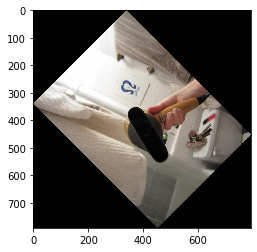

In [66]:
plt.imshow(rotated_image[:,:,::-1])

image_id  400161
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
bbox                     shape: (1, 4)                min:    0.00000  max:  390.00000  int32
mask                     shape: (1, 480, 640)         min:    0.00000  max:    1.00000  uint8
kepoint                  shape: (1, 17, 3)            min:    0.00000  max:  305.00000  float32


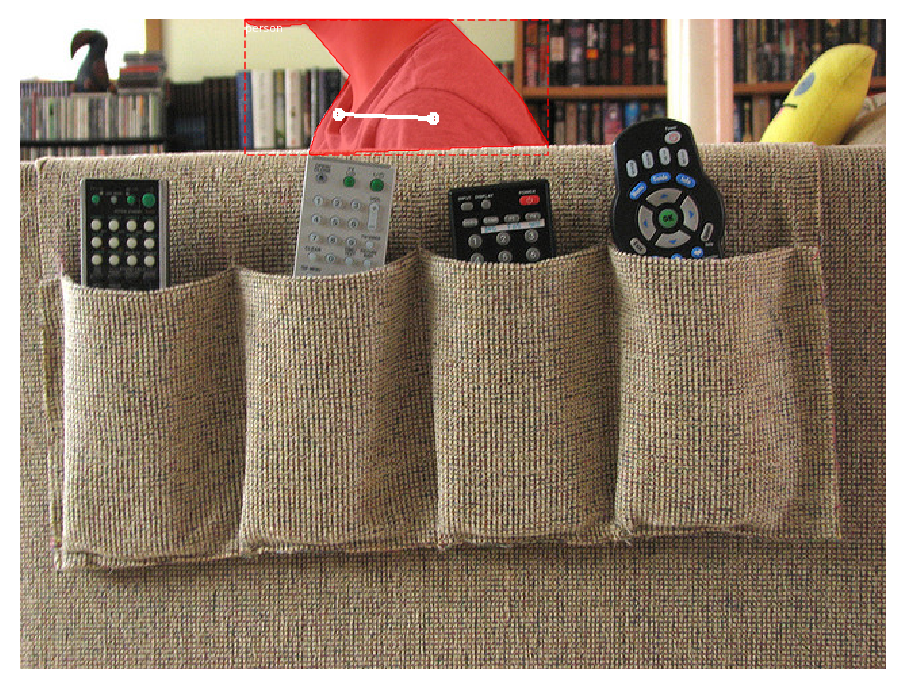

In [31]:
# Display image and additional stats
print("image_id ", img_id)
log("image", img)
log("bbox", bboxes)
log("mask", masks)
log("kepoint", keypoints)
# Display image and instances
class_ids = np.array([1]*len(bboxes))
class_names = np.array(['person']*len(bboxes))
display_instances(img[:,:,::-1], bboxes, masks, keypoints)


In [579]:
flipped = False

s = s * np.random.choice(np.arange(0.6, 1.4, 0.1))
w_border = _get_border(128, img.shape[1])
h_border = _get_border(128, img.shape[0])
c[0] = np.random.randint(low=w_border, high=img.shape[1] - w_border)
c[1] = np.random.randint(low=h_border, high=img.shape[0] - h_border)
    
print(cfg.DATASET.AUG_ROT)
if np.random.random() <cfg.DATASET.AUG_ROT:
    rf = cfg.DATASET.ROTATE
    rot = np.clip(np.random.randn()*rf, -rf*2, rf*2)

if np.random.random() < cfg.DATASET.FLIP:
    flipped = True
    img = img[:, ::-1, :]
    c[0] =  width - c[0] - 1
        
trans_input = get_affine_transform(
  c, s, rot, [cfg.MODEL.INPUT_RES, cfg.MODEL.INPUT_RES])
inp = cv2.warpAffine(img, trans_input, 
                     (cfg.MODEL.INPUT_RES, cfg.MODEL.INPUT_RES),
                     flags=cv2.INTER_LINEAR)    

0.0


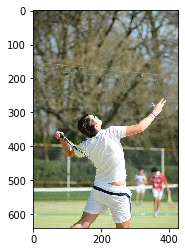

In [580]:
plt.imshow(img[:,:,::-1])

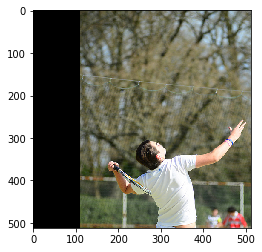

In [581]:
plt.imshow(inp[:,:,::-1])

In [582]:
output_res = cfg.MODEL.INPUT_RES
num_joints = 17
trans_output_rot = get_affine_transform(c, s, rot, [output_res, output_res])
trans_output = get_affine_transform(c, s, 0, [output_res, output_res])
trans_seg_output = get_affine_transform(c, s, 0, [output_res, output_res])
hm = np.zeros((1, output_res, output_res), dtype=np.float32)
hm_hp = np.zeros((num_joints, output_res, output_res), dtype=np.float32)

In [583]:
draw_gaussian = draw_msra_gaussian if cfg.LOSS.MSE_LOSS else \
                draw_umich_gaussian

image_id:  151629
image                    shape: (640, 427, 3)         min:    0.00000  max:  255.00000  uint8
mask                     shape: (3, 512, 512)         min:    0.00000  max:    1.00000  float32
bbox                     shape: (4,)                  min:  429.01001  max:  511.00000  float32


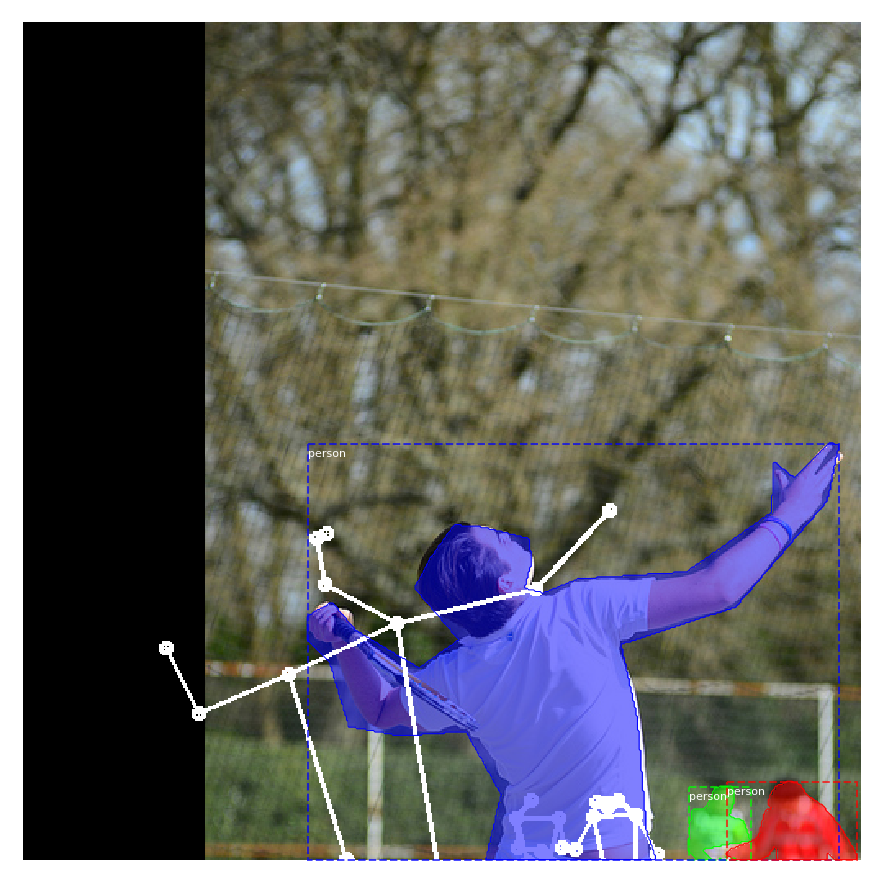

In [585]:
flip_idx = [[1, 2], [3, 4], [5, 6], [7, 8], [9, 10], 
          [11, 12], [13, 14], [15, 16]]

masks = []
bboxes = []
keypoints = []
for k in range(num_objs):
    ann = anns[k]
    bbox = _coco_box_to_bbox(ann['bbox'])
    cls_id = int(ann['category_id']) - 1
    pts = np.array(ann['keypoints'], np.float32).reshape(num_joints, 3)
    keypoints.append(pts)
    segment = coco_ins.annToMask(ann)      
    if flipped:
        bbox[[0, 2]] = width - bbox[[2, 0]] - 1
        pts[:, 0] = width - pts[:, 0] - 1
        for e in flip_idx:
            pts[e[0]], pts[e[1]] = pts[e[1]].copy(), pts[e[0]].copy()
        segment = segment[:, ::-1]     

    bbox[:2] = affine_transform(bbox[:2], trans_output)
    bbox[2:] = affine_transform(bbox[2:], trans_output)
    bbox = np.clip(bbox, 0, output_res - 1)
    segment= cv2.warpAffine(segment, trans_seg_output,
                         (output_res, output_res),
                         flags=cv2.INTER_LINEAR)
    segment = segment.astype(np.float32)      
    masks.append(segment)
    h, w = bbox[3] - bbox[1], bbox[2] - bbox[0]
    bboxes.append([bbox[1], bbox[0], bbox[3], bbox[2]])

    
    
bboxes = np.array(bboxes)
masks = np.array(masks)
keypoints = np.array(keypoints)

extracted_bbox = extract_bboxes(masks)

# Display image and additional stats
print("image_id: ", img_id)
log("image", img)
log("mask", masks)
log("bbox", bbox)
# Display image and instances
display_instances(inp[:,:,::-1], extracted_bbox, masks, keypoints)

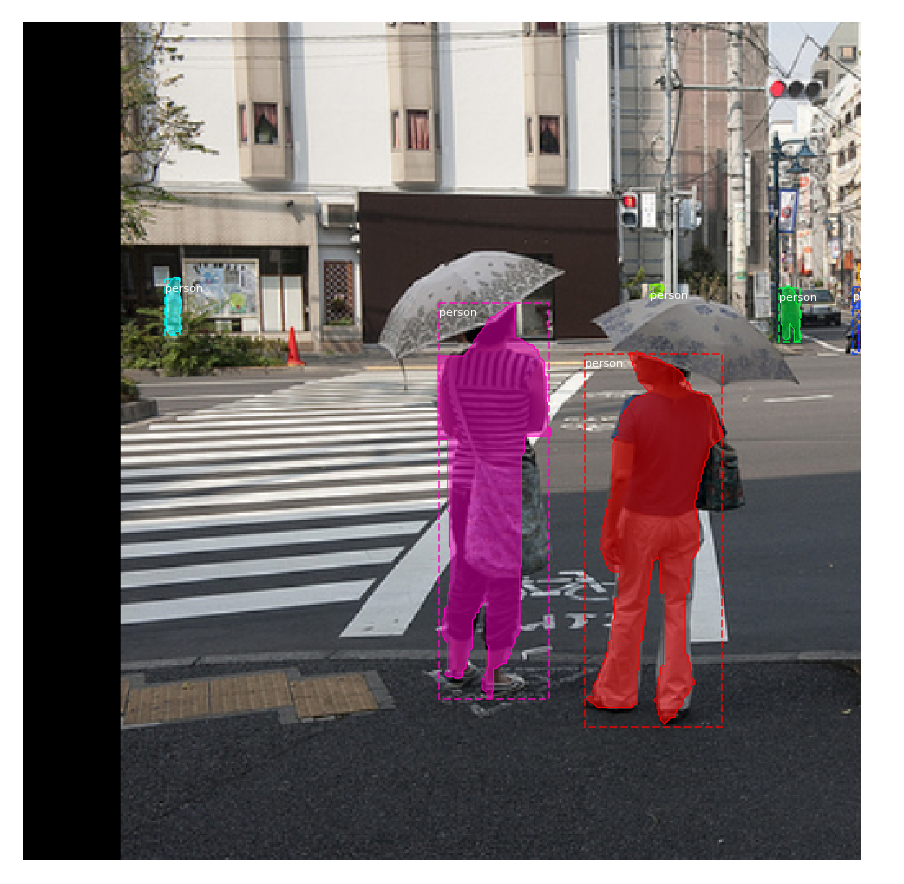

In [240]:
display_instances(inp[:,:,::-1], bboxes, masks)

In [241]:
_data_rng = np.random.RandomState(123)
_eig_val = np.array([0.2141788, 0.01817699, 0.00341571],
                         dtype=np.float32)
_eig_vec = np.array([
    [-0.58752847, -0.69563484, 0.41340352],
    [-0.5832747, 0.00994535, -0.81221408],
    [-0.56089297, 0.71832671, 0.41158938]
], dtype=np.float32)

if not cfg.DATASET.NO_COLOR_AUG:
    color_aug(_data_rng, inp, _eig_val, _eig_vec)

UFuncTypeError: Cannot cast ufunc 'multiply' output from dtype('float64') to dtype('uint8') with casting rule 'same_kind'

In [ ]:
def resize_image(image, min_dim=None, max_dim=None, min_scale=None, mode="square"):
    """Resizes an image keeping the aspect ratio unchanged.
    min_dim: if provided, resizes the image such that it's smaller
        dimension == min_dim
    max_dim: if provided, ensures that the image longest side doesn't
        exceed this value.
    min_scale: if provided, ensure that the image is scaled up by at least
        this percent even if min_dim doesn't require it.
    mode: Resizing mode.
        none: No resizing. Return the image unchanged.
        square: Resize and pad with zeros to get a square image
            of size [max_dim, max_dim].
        pad64: Pads width and height with zeros to make them multiples of 64.
               If min_dim or min_scale are provided, it scales the image up
               before padding. max_dim is ignored in this mode.
               The multiple of 64 is needed to ensure smooth scaling of feature
               maps up and down the 6 levels of the FPN pyramid (2**6=64).
        crop: Picks random crops from the image. First, scales the image based
              on min_dim and min_scale, then picks a random crop of
              size min_dim x min_dim. Can be used in training only.
              max_dim is not used in this mode.
    Returns:
    image: the resized image
    window: (y1, x1, y2, x2). If max_dim is provided, padding might
        be inserted in the returned image. If so, this window is the
        coordinates of the image part of the full image (excluding
        the padding). The x2, y2 pixels are not included.
    scale: The scale factor used to resize the image
    padding: Padding added to the image [(top, bottom), (left, right), (0, 0)]
    """
    # Keep track of image dtype and return results in the same dtype
    image_dtype = image.dtype
    # Default window (y1, x1, y2, x2) and default scale == 1.
    h, w = image.shape[:2]
    window = (0, 0, h, w)
    scale = 1
    padding = [(0, 0), (0, 0), (0, 0)]
    crop = None

    if mode == "none":
        return image, window, scale, padding, crop

    # Scale?
    if min_dim:
        # Scale up but not down
        scale = max(1, min_dim / min(h, w))
    if min_scale and scale < min_scale:
        scale = min_scale

    # Does it exceed max dim?
    if max_dim and mode == "square":
        image_max = max(h, w)
        if round(image_max * scale) > max_dim:
            scale = max_dim / image_max

    # Resize image using bilinear interpolation
    print(scale)
    if scale != 1:
        image = cv2.resize(image, (round(w * scale), round(h * scale)),
                       interpolation = cv2.INTER_NEAREST)
    print('scale', scale)
    # Need padding or cropping?
    if mode == "square":
        # Get new height and width
        h, w = image.shape[:2]
        top_pad = (max_dim - h) // 2
        bottom_pad = max_dim - h - top_pad
        left_pad = (max_dim - w) // 2
        right_pad = max_dim - w - left_pad
        padding = [(top_pad, bottom_pad), (left_pad, right_pad), (0, 0)]
        print('image before padding',image.shape)
        image = np.pad(image, padding, mode='constant', constant_values=0)
        window = (top_pad, left_pad, h + top_pad, w + left_pad)
        print(padding)
    elif mode == "pad64":
        h, w = image.shape[:2]
        # Both sides must be divisible by 64
        assert min_dim % 64 == 0, "Minimum dimension must be a multiple of 64"
        # Height
        if h % 64 > 0:
            max_h = h - (h % 64) + 64
            top_pad = (max_h - h) // 2
            bottom_pad = max_h - h - top_pad
        else:
            top_pad = bottom_pad = 0
        # Width
        if w % 64 > 0:
            max_w = w - (w % 64) + 64
            left_pad = (max_w - w) // 2
            right_pad = max_w - w - left_pad
        else:
            left_pad = right_pad = 0
        padding = [(top_pad, bottom_pad), (left_pad, right_pad), (0, 0)]
        image = np.pad(image, padding, mode='constant', constant_values=0)
        window = (top_pad, left_pad, h + top_pad, w + left_pad)
    elif mode == "crop":
        # Pick a random crop
        h, w = image.shape[:2]
        y = random.randint(0, (h - min_dim))
        x = random.randint(0, (w - min_dim))
        crop = (y, x, min_dim, min_dim)
        image = image[y:y + min_dim, x:x + min_dim]
        window = (0, 0, min_dim, min_dim)
    else:
        raise Exception("Mode {} not supported".format(mode))

    return image.astype(image_dtype), window, scale, padding, crop


def resize_mask(mask, scale, padding, crop=None):
    """Resizes a mask using the given scale and padding.
    Typically, you get the scale and padding from resize_image() to
    ensure both, the image and the mask, are resized consistently.
    scale: mask scaling factor
    padding: Padding to add to the mask in the form
            [(top, bottom), (left, right), (0, 0)]
    """
    # Suppress warning from scipy 0.13.0, the output shape of zoom() is
    # calculated with round() instead of int()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        print('mask shape', mask.shape)
        mask = scipy.ndimage.zoom(mask, zoom=[scale, scale, 1], order=0)
        print(scale)
        print('mask shape after', mask.shape)
        print(mask.shape)
    if crop is not None:
        y, x, h, w = crop
        mask = mask[y:y + h, x:x + w]
    else:
        mask = np.pad(mask, padding, mode='constant', constant_values=0)
    return mask

In [ ]:
img, window, scale, padding, _ = resize_image(
    img, 
    min_dim=None, 
    max_dim=512,
    mode='square')
masks = resize_mask(masks.transpose(1,2,0), scale, padding).transpose(2,0,1)
# Compute Bounding box
bbox = extract_bboxes(masks)

# Display image and additional stats
print("image_id: ", img_id)
log("image", img)
log("mask", masks)
log("bbox", bbox)
# Display image and instances
display_instances(img, bbox, masks, class_ids, class_names)